# Emperor Penguin - Present Day access and colonies
- Plot EP colony distances on CESM grid with typical polynyas and colony locations+size
- Needs to load files of EP colony distance and population
- Notebook by Alice DuVivier (NCAR)
- July 2025

In [1]:
import utils
import pandas as pd
import xarray as xr
import numpy as np
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd

## Read in penguin data

In [2]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

### Read Emperor penguin data

In [3]:
# Read in EP colony location/population data
file_in = 'CESM_grid_Emperor_colony_present_day.nc'
ds_ep_col= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [4]:
# get colony population info for plotting
ep_data_col_pop = ds_ep_col.colony_pop
ep_data_col_lat = ds_ep_col.colony_lat
ep_data_col_lon = ds_ep_col.colony_lon

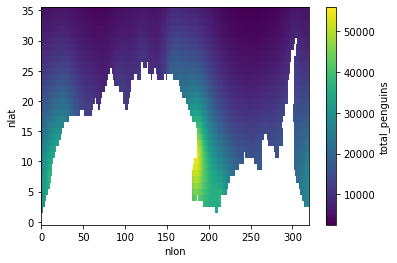

In [5]:
# Read in EP accessibility data 
file_in = 'CESM_grid_Emperor_individual_access_present_day.nc'
ds_ep= xr.open_mfdataset(dir_in+file_in,decode_times=False)

ep_total_penguins = ds_ep.total_penguins
ep_total_penguins.plot()

### Read Adelie penguin data

In [6]:
# Read in AP colony location/population data
file_in = 'CESM_grid_Adelie_colony_present_day.nc'
ds_ap_col= xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [7]:
# get colony population info for plotting
ap_data_col_pop = ds_ap_col.colony_pop
ap_data_col_lat = ds_ap_col.colony_lat
ap_data_col_lon = ds_ap_col.colony_lon

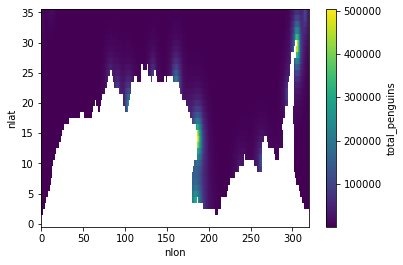

In [8]:
# Read in AP accessibility data 
file_in = 'CESM_grid_Adelie_individual_access_present_day.nc'
ds_ap= xr.open_mfdataset(dir_in+file_in,decode_times=False)

ap_total_penguins = ds_ap.total_penguins
ap_total_penguins.plot()

### Load regional mask data and shapefiles

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [10]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [11]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [12]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [13]:
lons = ds_ep.TLONG
lats = ds_ep.TLAT

### Set plotting ranges, etc.

In [14]:
# maximum individuals at a point
ep_total_penguins.max(dim=['nlat','nlon']).values

array(55839.44871268)

In [15]:
# maximum individuals at a point
ap_total_penguins.max(dim=['nlat','nlon']).values

array(503963.0771668)

In [16]:
# set some plotting info

# EP
ep_cmap_in = cmocean.cm.dense
ep_vmin_in = 0.0
ep_vmax_in = 50000.0

# AP
ap_cmap_in = cmocean.cm.ice_r
ap_vmin_in = 0.0
ap_vmax_in = 300000.0

In [64]:
# EP: set circle areas for colonies
# loop through each colony population and set it based on 5 bins
# 1 --> population values of 2 (too small to be measured by satellite): A = 25
# 2 --> population 0-999: A = 50
# 3 --> population 1000-4999: A = 100
# 4 --> population 5000-9999: A = 250
# 5 --> population > 10000: A = 500

clen = len(ds_ep_col.index)
ep_area = np.zeros([clen])

for col in np.arange(0,clen,1):
    pop = ep_data_col_pop.isel(index=col)
    if (pop == 2):
        ep_area[col] = 25
    elif ((pop > 2) and (pop <= 999)):
        ep_area[col] = 50
    elif ((pop > 1000) and (pop <= 4999)):
        ep_area[col] = 100
    elif ((pop > 5000) and (pop <= 9999)):
        ep_area[col] = 250
    elif (pop > 10000):
        ep_area[col] = 500

# Set some lats/lons, etc. for a legend
ep_lons_leg = [0,0,0,0,180]
ep_lats_leg = [-81.5,-83.5,-86.0,-88.5,-88.5]
ep_area_leg = [25,50,100,250,500]
ep_text_leg = ['Unknown','< 1,000','1,000-4,999','5,000-9,999','> 10,000']

In [65]:
# AP: set circle areas for colonies
# loop through each colony population and set it based on 5 bins
# 1 --> population values of 2 (too small to be measured by satellite): A = 25
# 2 --> population 0-1999: A = 50
# 3 --> population 2000-19999: A = 100
# 4 --> population 20000-999999: A = 250
# 5 --> population > 100000: A = 500

clen = len(ds_ap_col.index)
ap_area = np.zeros([clen])

for col in np.arange(0,clen,1):
    pop = ap_data_col_pop.isel(index=col)
    if (pop == 2):
        ap_area[col] = 25
    elif ((pop > 2) and (pop <= 1999)):
        ap_area[col] = 50
    elif ((pop > 2000) and (pop <= 19999)):
        ap_area[col] = 100
    elif ((pop > 20000) and (pop <= 99999)):
        ap_area[col] = 250
    elif (pop > 100000):
        ap_area[col] = 500

# Set some lats/lons, etc. for a legend
ap_lons_leg = [0,0,0,0,180]
ap_lats_leg = [-81.0,-83.5,-86.0,-88.5,-88.5]
ap_area_leg = [25,50,100,250,500]
ap_text_leg = ['Unknown','< 2,000','2,000-19,999','20,000-99,999','> 100,000']

### Save plot

In [20]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'SFig_Penguin_access_present_day'

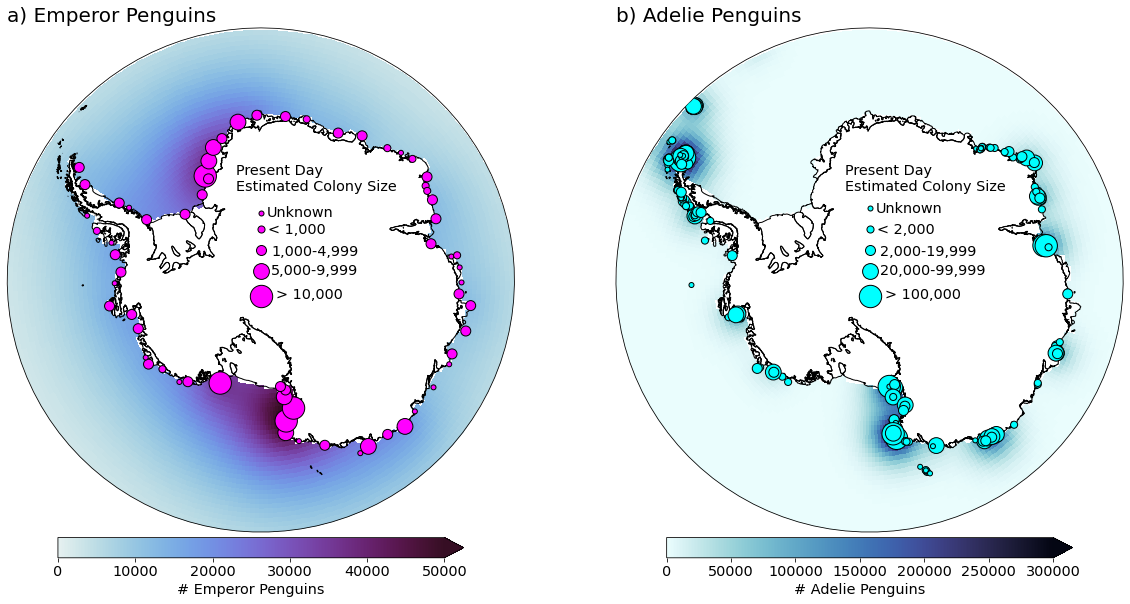

In [85]:
# Plot
# create figure
fig = plt.figure(figsize=(20,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### EMPEROR PENGUINS ###
ax = fig.add_subplot(1,2,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('a) Emperor Penguins', loc='left',fontsize=20)
### Plot EP distance info
lon, lat, field = utils.adjust_pop_grid(lons,lats,ep_total_penguins)
this=ax.pcolormesh(lon,lat,
                   field,
                   cmap=ep_cmap_in,                      
                   vmax=ep_vmax_in, vmin=ep_vmin_in,
                   transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('# Emperor Penguins',fontsize='x-large')
### Add shapefile coastlines - before colony locations!
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(ep_data_col_lon,ep_data_col_lat,
                 color='magenta', edgecolor='black', s=ep_area,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
### Add legend for colony size
# text for legend
this2=ax.text(-15.0,-78.5,
              'Present Day\nEstimated Colony Size',
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = ep_lons_leg[n]
lat_plt = ep_lats_leg[n]
area_plt = ep_area_leg[n]
text_plt = ep_text_leg[n]
this3=ax.scatter(lon_plt,lat_plt,
                 color='magenta', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax.text(lon_plt+5,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = ep_lons_leg[n]
lat_plt = ep_lats_leg[n]
area_plt = ep_area_leg[n]
text_plt = ep_text_leg[n]
this4=ax.scatter(lon_plt,lat_plt,
                 color='magenta', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax.text(lon_plt+8,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = ep_lons_leg[n]
lat_plt = ep_lats_leg[n]
area_plt = ep_area_leg[n]
text_plt = ep_text_leg[n]
this5=ax.scatter(lon_plt,lat_plt,
                 color='magenta', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax.text(lon_plt+20,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = ep_lons_leg[n]
lat_plt = ep_lats_leg[n]
area_plt = ep_area_leg[n]
text_plt = ep_text_leg[n]
this6=ax.scatter(lon_plt,lat_plt,
                 color='magenta', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax.text(lon_plt+50,lat_plt+0.1,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fifth dot
n = 4
lon_plt = ep_lons_leg[n]
lat_plt = ep_lats_leg[n]
area_plt = ep_area_leg[n]
text_plt = ep_text_leg[n]
this7=ax.scatter(lon_plt,lat_plt,
                 color='magenta', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this7t=ax.text(lon_plt-45,lat_plt+1.0,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())

### ADELIE PENGUINS ###
ax = fig.add_subplot(1,2,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('b) Adelie Penguins', loc='left',fontsize=20)
### Plot EP distance info
lon, lat, field = utils.adjust_pop_grid(lons,lats,ap_total_penguins)
this=ax.pcolormesh(lon,lat,
                   field,
                   cmap=ap_cmap_in,                      
                   vmax=ap_vmax_in, vmin=ap_vmin_in,
                   transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='x-large')
cbar.ax.set_xlabel('# Adelie Penguins',fontsize='x-large')
### Add shapefile coastlines - before colony locations!
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
### Plot Colony Locations - sizes vary by colony size
this1=ax.scatter(ap_data_col_lon,ap_data_col_lat,
                 color='cyan', edgecolor='black', s=ap_area,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
### Add legend for colony size
# text for legend
this2=ax.text(-15.0,-78.5,
              'Present Day\nEstimated Colony Size',
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# first dot
n = 0
lon_plt = ap_lons_leg[n]
lat_plt = ap_lats_leg[n]
area_plt = ap_area_leg[n]
text_plt = ap_text_leg[n]
this3=ax.scatter(lon_plt,lat_plt,
                 color='cyan', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this3t=ax.text(lon_plt+5,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# second dot
n = 1
lon_plt = ap_lons_leg[n]
lat_plt = ap_lats_leg[n]
area_plt = ap_area_leg[n]
text_plt = ap_text_leg[n]
this4=ax.scatter(lon_plt,lat_plt,
                 color='cyan', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this4t=ax.text(lon_plt+8,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# third dot
n = 2
lon_plt = ap_lons_leg[n]
lat_plt = ap_lats_leg[n]
area_plt = ap_area_leg[n]
text_plt = ap_text_leg[n]
this5=ax.scatter(lon_plt,lat_plt,
                 color='cyan', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this5t=ax.text(lon_plt+20,lat_plt-0.5,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fourth dot
n = 3
lon_plt = ap_lons_leg[n]
lat_plt = ap_lats_leg[n]
area_plt = ap_area_leg[n]
text_plt = ap_text_leg[n]
this6=ax.scatter(lon_plt,lat_plt,
                 color='cyan', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this6t=ax.text(lon_plt+50,lat_plt+0.1,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())
# fifth dot
n = 4
lon_plt = ap_lons_leg[n]
lat_plt = ap_lats_leg[n]
area_plt = ap_area_leg[n]
text_plt = ap_text_leg[n]
this7=ax.scatter(lon_plt,lat_plt,
                 color='cyan', edgecolor='black', s=area_plt,
                 zorder = 100,
                 transform=ccrs.PlateCarree())
this7t=ax.text(lon_plt-45,lat_plt+1.0,
              text_plt,
              color='black', fontsize='x-large',
              transform=ccrs.PlateCarree())

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)